# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM = 42
state = RandomState(RANDOM) 

Загружаем и изучаем датасеты

In [3]:
import os

pth1 = 'C:/Users/rank-/OneDrive/Рабочий стол/Проекты аналитика/МО в Бизнесе/датасеты/geo_data_0.csv'
pth2 = 'C:/Users/rank-/OneDrive/Рабочий стол/Проекты аналитика/МО в Бизнесе/датасеты/geo_data_1.csv'
pth3 = 'C:/Users/rank-/OneDrive/Рабочий стол/Проекты аналитика/МО в Бизнесе/датасеты/geo_data_2.csv'

pth_1 = '/datasets/geo_data_0.csv'
pth_2 = '/datasets/geo_data_1.csv'
pth_3 = '/datasets/geo_data_2.csv'
if os.path.exists(pth1):
    geo_data_0 = pd.read_csv(pth1)
    geo_data_1 = pd.read_csv(pth2)
    geo_data_2 = pd.read_csv(pth3)
else:
    geo_data_0 = pd.read_csv(pth_1)
    geo_data_1 = pd.read_csv(pth_2)
    geo_data_2 = pd.read_csv(pth_3)

In [4]:
# Напишем функцию для получения общей информации о датасете
def get_info(data):
    display(data.head())
    display(data.info())
    display(data.describe().T)
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('Кол-во пропусков:\n', data.isna().sum())

In [5]:
get_info(geo_data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Кол-во явных дубликатов: 0
Кол-во пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [6]:
get_info(geo_data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Кол-во явных дубликатов: 0
Кол-во пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [7]:
get_info(geo_data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Кол-во явных дубликатов: 0
Кол-во пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [8]:
def check_columns(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())

In [9]:
check_columns(geo_data_0)

Уникальные значения столбца id
['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']
Уникальные значения столбца f0
[0.70574498 1.33471129 1.02273226 ... 1.02958465 0.99816289 1.76475393]
Уникальные значения столбца f1
[-0.4978225  -0.34016425  0.15199044 ...  0.01878693 -0.52858167
 -0.26641676]
Уникальные значения столбца f2
[ 1.22116995  4.36508033  1.41992624 ... -1.34830814  1.58386866
  5.72284937]
Уникальные значения столбца product
[105.28006184  73.03775027  85.26564713 ...  64.37544259  74.04076435
 149.63324561]


In [10]:
# Выведем словарь, где ключ -> название столбца, а значение -> список уникальных значений столбца
[{i: list(geo_data_0[i].unique())} for i in geo_data_0.columns if geo_data_0[i].dtype == 'object']

[{'id': ['txEyH',
   '2acmU',
   '409Wp',
   'iJLyR',
   'Xdl7t',
   'wX4Hy',
   'tL6pL',
   'BYPU6',
   'j9Oui',
   'OLuZU',
   'b8WQ6',
   '1YYm1',
   'zIYPq',
   'iqTqq',
   'Ct5yY',
   'Q77WQ',
   '6vJcD',
   'AgRR6',
   'tgSSC',
   's2g8E',
   '94tLD',
   'x4axC',
   'MlCYx',
   'vYLce',
   'RyD7G',
   'HgCfr',
   'DoIei',
   '6Gdw6',
   'gjrQG',
   'bkKez',
   'jnQyF',
   't86xZ',
   'lSO9H',
   'kkBK1',
   'Gbj0z',
   'ZKRFP',
   'ZyXT7',
   'TdSKv',
   'R9ocw',
   'Fo4B8',
   'PXZCd',
   'u8Y1U',
   '3TANG',
   'nCqKF',
   'Qq9CO',
   'brqzz',
   'MI4Nr',
   '978oy',
   'w6xb4',
   'X0eqC',
   '2pnAs',
   'VluBu',
   'dydBa',
   'CslzZ',
   'CtLdb',
   'kNbyW',
   'P2LGU',
   '8pdd4',
   'So9YB',
   '7qZov',
   'F2uKY',
   'tjgXy',
   'kXGy9',
   '0WHqb',
   'sfT7k',
   'EDOXV',
   'WdnTQ',
   'UdIUW',
   '7Ivop',
   '5GhWs',
   'FNNrY',
   'EyYt0',
   'DhiTZ',
   'jQ1H0',
   'qt3N3',
   'ldWPw',
   'yakdw',
   'Yiien',
   'J1qvF',
   'oeTLA',
   'xKWM3',
   'SbvEW',
   'vP0qz'

In [11]:
check_columns(geo_data_1)

Уникальные значения столбца id
['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']
Уникальные значения столбца f0
[-15.00134818  14.27208781   6.26318735 ...  -7.37889139   0.66571381
  -3.42613898]
Уникальные значения столбца f1
[-8.27599995 -3.47508322 -5.94838579 ... -3.08410387 -6.15259286
 -7.7942742 ]
Уникальные значения столбца f2
[-5.87601369e-03  9.99182737e-01  5.00116016e+00 ...  4.99865060e+00
  1.00014635e+00 -3.29851829e-03]
Уникальные значения столбца product
[  3.17910258  26.95326103 134.76630516 137.94540774  84.03888568
 110.99214671  53.90652206   0.         107.81304413  57.08562465
  30.13236361  80.85978309]


In [12]:
# Выведем словарь, где ключ -> название столбца, а значение -> список уникальных значений столбца
[{i: list(geo_data_1[i].unique())} for i in geo_data_1.columns if geo_data_1[i].dtype == 'object']

[{'id': ['kBEdx',
   '62mP7',
   'vyE1P',
   'KcrkZ',
   'AHL4O',
   'HHckp',
   'h5Ujo',
   'muH9x',
   'YiRkx',
   'jG6Gi',
   '7uHUe',
   'OXyvW',
   'cB8re',
   'igmai',
   '3OdkE',
   '3tVUO',
   'siveY',
   'gIqzq',
   'zO5EU',
   'dkcEb',
   'X1FZJ',
   'eVFPS',
   'TovFu',
   'KQxAV',
   'II0xj',
   'AOrbK',
   'DbtST',
   'mqtSN',
   'dqN1d',
   'JPiGi',
   'YVVPX',
   '4NJv3',
   '2DKVI',
   'M57PU',
   '5O3Zt',
   'BZWmy',
   'aArVp',
   'EHH3V',
   'fNWXc',
   '957X9',
   'qytqc',
   'GrqpD',
   'MLsxX',
   'bBa22',
   'xIzLU',
   'XIVZM',
   'eFEKx',
   'pCJ6F',
   '99v70',
   'M3bnc',
   'tBuZC',
   '5IdNU',
   'kdlYD',
   'vPO9F',
   '86e7T',
   'hsHjt',
   '56IYh',
   'NTapr',
   '3Wuq9',
   'vpHM5',
   '2edYH',
   'a1jWE',
   'Qjy5w',
   'G6WCj',
   'NxRPd',
   'EI98u',
   'cpJzM',
   'A0eOb',
   '75iHe',
   'VSSdd',
   'lVMxj',
   'hi6yq',
   'o7x4E',
   '01qMa',
   'OyyAo',
   '6H2Ab',
   'QcBYZ',
   'MzQhL',
   'VjV7l',
   'uWlnT',
   'BCfvH',
   'gdvra',
   'VHp5v'

In [13]:
check_columns(geo_data_2)

Уникальные значения столбца id
['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']
Уникальные значения столбца f0
[-1.1469871   0.2627779   0.19458728 ... -1.19993432 -2.41989641
 -2.55142066]
Уникальные значения столбца f1
[ 0.96332792  0.26983896  0.289035   ... -2.95763723  2.41722066
 -2.02562514]
Уникальные значения столбца f2
[-0.82896492 -2.53018652 -5.58643277 ...  5.219411   -5.54844392
  6.09089066]
Уникальные значения столбца product
[ 27.75867323  56.06969663  62.87191005 ... 157.08007975  51.79525299
 102.77576749]


In [14]:
# Выведем словарь, где ключ -> название столбца, а значение -> список уникальных значений столбца
[{i: list(geo_data_2[i].unique())} for i in geo_data_2.columns if geo_data_2[i].dtype == 'object']

[{'id': ['fwXo0',
   'WJtFt',
   'ovLUW',
   'q6cA6',
   'WPMUX',
   'LzZXx',
   'WBHRv',
   'XO8fn',
   'ybmQ5',
   'OilcN',
   'myq2g',
   'V9R1y',
   'bKDo0',
   'eXvhs',
   'wI4j3',
   'XOWTx',
   '2oVFv',
   '0wbDA',
   'NhHaR',
   'DMNMZ',
   '3mCRf',
   'fRllb',
   '6GvzI',
   'JwbXn',
   'urwUC',
   'KMQl3',
   'Coy8M',
   'EXElh',
   'uaZJK',
   '6UkRY',
   'PMtzo',
   'y3a1h',
   'wBJrC',
   'KLqMx',
   'HE3Rv',
   'FAoc2',
   'dQ5QX',
   'FmeFh',
   'nja19',
   'I0A8A',
   'Xps9D',
   'XYtEF',
   '5LlUY',
   'G76Yc',
   '4tbf0',
   'NYpGH',
   '8N91V',
   'AvYBo',
   'MqzmX',
   'LLbXy',
   '4YQ9S',
   '1vUJf',
   'IMTor',
   'SAYyn',
   'yk8lT',
   'SD6l6',
   'Ezgjl',
   '0lNJH',
   'UJr17',
   'DxBlb',
   '1gG2P',
   'eUBYm',
   'UZglt',
   'IDkMX',
   '9HSTp',
   'c7uIs',
   'clzaw',
   'WedK5',
   '091iG',
   'leREP',
   'JJQld',
   'GiuCK',
   'B8dcy',
   'fDxBG',
   'XHQ64',
   'sM8C8',
   'wIc5h',
   'p8KjR',
   'OfEbI',
   'J2PSf',
   'ZIED0',
   'jjKEK',
   'cqBhZ'

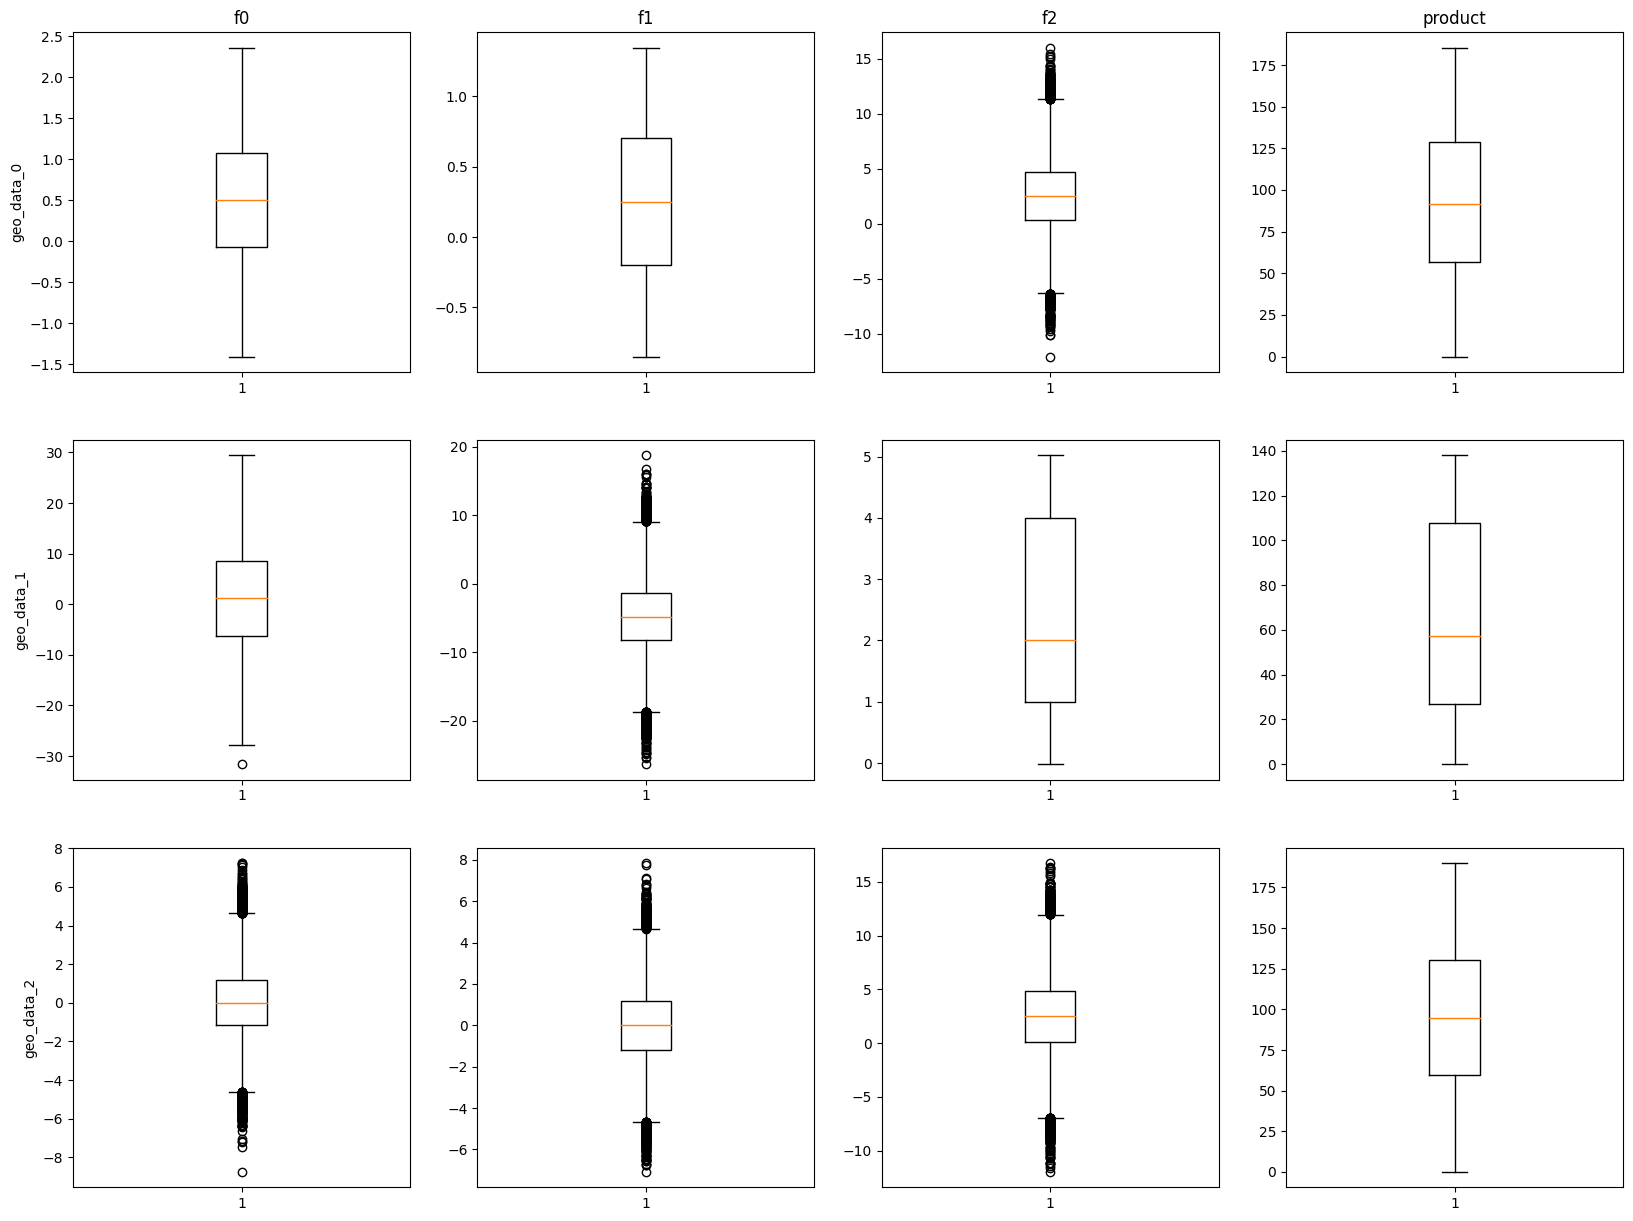

In [15]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["geo_data_0","geo_data_1","geo_data_2"]
num_columns = geo_data_0.columns[1:]
num_columns_with_columns = zip(geo_data_0.columns[1:],range(4))
all_frames_with_rows = zip([geo_data_0,geo_data_1,geo_data_2],range(3))
# Построим графики
for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Добавим название фрейма изображаемого на графике
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
# Добавим название столбца изображаемого на графике
for column in range(4):
    ax[0][column].set_title(num_columns[column])

Заметим, что в некоторых столбцах есть данные, выходящие за границы. Эти данные будут мешать модели обучаться, отвлекая её. Поэтому их необходимо удалить. Выпишем необходимые столбцы для обработки в формате - (датасет, столбец):

- (geo_data_0,"f2")
- (geo_data_1,"f1")
- (geo_data_2,"f0")
- (geo_data_2,"f1")
- (geo_data_2,"f2")

Исправим недочеты, обнаруженные в данных:

In [16]:
def remove_ouliers(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

In [17]:
noise_data = [(geo_data_0,"f2"),
 (geo_data_1,"f1"),
 (geo_data_2,"f0"),
 (geo_data_2,"f1"),
 (geo_data_2,"f2")]

for frame,column in noise_data:
    indexes = remove_ouliers(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)

Количество строк, выбранных для удаления:  506
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  733
Количество строк, выбранных для удаления:  682
Количество строк, выбранных для удаления:  582


Выборки пострадали не сильно, в первых двух потери составили менее 1%, в последней же потеря данных составила 2%

In [18]:
geo_data_0 = geo_data_0.reset_index(drop = True)
geo_data_1 = geo_data_1.reset_index(drop = True)
geo_data_2 = geo_data_2.reset_index(drop = True)

**Проверим корреляцию между признаками в выборках:**

In [19]:
geo_data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440716,-0.003339,0.143591
f1,-0.440716,1.000000,0.001098,-0.192748
f2,-0.003339,0.001098,1.000000,0.480159
product,0.143591,-0.192748,0.480159,1.000000


In [20]:
geo_data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.178877,-0.001670,-0.030389
f1,0.178877,1.000000,-0.002756,-0.010174
f2,-0.001670,-0.002756,1.000000,0.999397
product,-0.030389,-0.010174,0.999397,1.000000


In [21]:
geo_data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000649,0.000473,-0.002962
f1,0.000649,1.000000,0.000710,-0.000895
f2,0.000473,0.000710,1.000000,0.441211
product,-0.002962,-0.000895,0.441211,1.000000


Заметим, что в нулевом датасете признаки f0 и f1 отрицательно коррелируют относительно друг друга и f2 слабо положительно коррелирует с целевым признаком. Так же в первом датасете очень сильно коррелирует целевой признак и f2. Во втором датасете так же есть коррелирующие признаки, такие как f2 и product.

Если в случае с первым датасетом все достаточно понятно, там очень высокая корреляция и признак f2 следует удалить, то вот в случае с другими двумя выборками стоит опираться на результат, который мы получим на моделях, Следовательно необходимо подготовить 3 выборок:

- Нулевая со всеми столбцами
- Первая без f2
- Вторая со всеми столбцами

In [22]:
geo_data_1_out_f2 = geo_data_1.drop(["f2"],axis = 1)

**Вывод**  

Результаты первичного анализа:

Пропусков и явных дубликатов нет  
Типы столбцов - корректны  
Названия столбцов - корректны  
Объем запасов - положительный  
Выбросы - удалены  
Коррелирующие признаки - учтены  

## Обучение и проверка модели

Выполняем разбивку неподготовленного датафрейма.

In [23]:
array_name = ["geo_data_0",
              "geo_data_2",
              "geo_data_1_out_f2"]

array_frame = [geo_data_0,
              geo_data_2,
              geo_data_1_out_f2]

data_dict = {"pipelines":{},"scores":{},"valid":{}}

for frame, name in zip(array_frame,array_name):
    
    features = frame.drop(["id","product"], axis = 1)
    target = frame["product"]
    
    new_pipeline = make_pipeline(StandardScaler(),LinearRegression())
    
    
    (features_train,
    features_valid,
    target_train,
    target_valid) = train_test_split(features,
                                     target,
                                     test_size = 0.25,
                                     random_state = RANDOM)
    data_dict['valid'][name] = (features_valid,target_valid)
    new_pipeline.fit(features_train,target_train)
    
    data_dict['pipelines'][name] = new_pipeline
    data_dict['scores'][name] = mean_squared_error(target_valid,
                                                   new_pipeline.predict(features_valid))**0.5

In [24]:
data_dict['scores']

{'geo_data_0': 37.815104778634264,
 'geo_data_2': 40.12959008344122,
 'geo_data_1_out_f2': 45.99719288701953}

Выборка с минимальной ошибкой:

- Нулевой регион: 'geo_data_0'
- Первый регион: "geo_data_1_out_f2"
- Второй регион: 'geo_data_2'

In [25]:
best_model_0 = data_dict['pipelines']['geo_data_0']
best_model_1 = data_dict['pipelines']['geo_data_1_out_f2']
best_model_2 = data_dict['pipelines']['geo_data_2']

predicted_values_0 = best_model_0.predict(data_dict['valid']['geo_data_0'][0])
predicted_values_1 = best_model_1.predict(data_dict['valid']['geo_data_1_out_f2'][0])
predicted_values_2 = best_model_2.predict(data_dict['valid']['geo_data_2'][0])

RMSE_model_0 = (mean_squared_error(data_dict['valid']['geo_data_0'][1],predicted_values_0))**0.5
RMSE_model_1 = (mean_squared_error(data_dict['valid']['geo_data_1_out_f2'][1],predicted_values_1))**0.5
RMSE_model_2 = (mean_squared_error(data_dict['valid']['geo_data_2'][1],predicted_values_2))**0.5

In [26]:
display({
    'Средний запас': predicted_values_0.mean(),
    'RMSE модели': RMSE_model_0
})

display({
    'Средний запас': predicted_values_1.mean(),
    'RMSE модели': RMSE_model_1
})

display({
    'Средний запас': predicted_values_2.mean(),
    'RMSE модели': RMSE_model_2
})

{'Средний запас': 92.3505469646708, 'RMSE модели': 37.815104778634264}

{'Средний запас': 68.90081167842224, 'RMSE модели': 45.99719288701953}

{'Средний запас': 94.9517811076183, 'RMSE модели': 40.12959008344122}

**Вывод:**  


**Нулевой регион:**  
Ошибка в нулевом регионе самая маленькая, но по среднему объему запасов регион на втором месте  


**Первый регион:**  
Проигрывает другим регионам и по показателю средней ошибки и по среднему объему запасов  


**Второй регион:**  
Самый большой средний объем запасов, но по ошибке регион на втором месте  

## Подготовка к расчёту прибыли

**Создадим переменные об экономической информации.**

In [27]:
BUDGET_PER_REGION = 10*(10**9)
PRE_MAX_POINTS = 500
FINAL_MAX_POINTS = 200
PRICE_PER_BARREL = 450000
DAMAGE_THRESHOLD =  0.025
NON_DAMAGE_POINT = (BUDGET_PER_REGION/(PRICE_PER_BARREL*(10**3)))/(FINAL_MAX_POINTS)

Расчитаем безубыточную разработку сырья и посмотрим запасы на скважину. И найдем среднее количество продукта в месторождениях необходимое для этого.

In [28]:
print("Достаточный объем добычи для безубыточной разработки",round(NON_DAMAGE_POINT,2))
print('Средний запас фактичекой нефти на скважину в регионе 1', geo_data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2', geo_data_1_out_f2['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3', geo_data_2['product'].mean())

Достаточный объем добычи для безубыточной разработки 0.11
Средний запас фактичекой нефти на скважину в регионе 1 92.50067661514835
Средний запас фактичекой нефти на скважину в регионе 2 68.80991858101544
Средний запас фактичекой нефти на скважину в регионе 3 94.78507187440762


Посмотрим распределение значений по районам:

In [29]:
geo_data_0.describe()

,f0,f1,f2,product
count,99494.000000,99494.000000,99494.000000,99494.000000
mean,0.500570,0.250044,2.503399,92.500677
std,0.871838,0.504437,3.181196,44.229330
min,-1.408605,-0.848218,-6.352956,0.000000
25%,-0.072378,-0.201063,0.301496,56.567678
50%,0.502606,0.250032,2.516336,91.842533
75%,1.073729,0.700574,4.704256,128.517876
max,2.362331,1.343769,11.353804,185.364347


In [30]:
geo_data_1_out_f2.describe()

,f0,f1,product
count,99364.000000,99364.000000,99364.000000
mean,1.139661,-4.803101,68.809919
std,8.966349,4.984107,45.934941
min,-31.609576,-18.667777,0.000000
25%,-6.300689,-8.249871,26.953261
50%,1.150044,-4.816643,57.085625
75%,8.621015,-1.363538,107.813044
max,29.421755,9.050688,137.945408


In [31]:
geo_data_2.describe()

,f0,f1,f2,product
count,98003.000000,98003.000000,98003.000000,98003.000000
mean,0.000788,-0.002182,2.494648,94.785072
std,1.679981,1.681475,3.389780,44.685282
min,-4.640830,-4.676782,-6.944602,0.000000
25%,-1.153136,-1.164226,0.147699,59.330119
50%,0.008893,-0.009345,2.482845,94.696578
75%,1.148220,1.155001,4.841025,130.319425
max,4.637965,4.670610,11.945919,190.029838


В соответствии с найденной точкой безубыточности все регионы нам подходят

In [32]:
print("25% скважин в нулевом регионе содержат больше сырья, чем ",
      round(geo_data_0["product"].quantile(0.75),2))
print("16% скважин в нулевом регионе содержат больше сырья, чем ",
      round(geo_data_1_out_f2["product"].quantile(0.84),2))
print("25% скважин в нулевом регионе содержат больше сырья, чем ",
      round(geo_data_2["product"].quantile(0.80),2))

25% скважин в нулевом регионе содержат больше сырья, чем  128.52
16% скважин в нулевом регионе содержат больше сырья, чем  134.77
25% скважин в нулевом регионе содержат больше сырья, чем  136.68


**Вывод**  


Минимальное количество баррелей нефти для безубыточной разработки составило 111.(1)

В тоже время максимальное средний объем в регионах равен 94. Если обратить внимание на распределение объема запасов по району, можно заметить, что в нулевом и втором районах 20% скважин проходят минимальный порог(учитывая объемы выборок, 20% составляют чуть меньше 20 000 скважин)

В то время как в первом районе подходят только 16% скважин

## Расчёт прибыли и рисков 

Просчитаем прибыль

In [33]:
def income(true_target, pred_target):
    sort_Series = pd.Series(pred_target).sort_values(ascending=False)[:FINAL_MAX_POINTS]
    true_target_sort = (true_target
                         .reset_index(drop = True)[sort_Series.index])
    sum_true = true_target_sort.sum() 
    return round((sum_true * PRICE_PER_BARREL) - BUDGET_PER_REGION,2)

In [34]:
print("Прибыль с лучших 200 скважин в нулевом регионе:",income(data_dict['valid']['geo_data_0'][1],
                                                               predicted_values_0))
print("Прибыль с лучших 200 скважин во втором регионе:",income(data_dict['valid']['geo_data_2'][1],
                                                               predicted_values_2))
print("Прибыль с лучших 200 скважин в первом регионе:",income(data_dict['valid']['geo_data_1_out_f2'][1],
                                                               predicted_values_1))

Прибыль с лучших 200 скважин в нулевом регионе: 3252359903.11
Прибыль с лучших 200 скважин во втором регионе: 2385314465.93
Прибыль с лучших 200 скважин в первом регионе: -3600881165.56


Проведем процедуру Bootstrap

In [35]:
def confidence_interval(true_target,pred_target):
    samples = []
    for i in tqdm(range(1000)):
        sample = pd.Series(pred_target).sample(n = PRE_MAX_POINTS, replace=True, random_state=state)
        samples.append(income(true_target,sample))
    samples = pd.Series(samples)
    print(samples.mean())
    print(samples.apply(lambda x: x < 0).sum()/len(samples)*100,"%")
    
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.975)
    return round(lower,2), round(upper,2)

In [36]:
print("95% доверительный итервал для Нулевового региона лежит между:",
      confidence_interval(data_dict['valid']['geo_data_0'][1],pd.Series(predicted_values_0)))
print()
print("95% Доверительный итервал для Второго региона лежит между:",
      confidence_interval(data_dict['valid']['geo_data_2'][1],predicted_values_2))
print()
print("95% Доверительный итервал для Первого  региона лежит между:",
      confidence_interval(data_dict['valid']['geo_data_1_out_f2'][1],predicted_values_1))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 417.33it/s]


381840608.64294
6.7 %
95% доверительный итервал для Нулевового региона лежит между: (-110929096.14, 891087236.3)



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 554.16it/s]


382973380.2275
7.000000000000001 %
95% Доверительный итервал для Второго региона лежит между: (-142559672.52, 900660974.77)



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 554.43it/s]

-3737868025.4926105
100.0 %
95% Доверительный итервал для Первого  региона лежит между: (-4293770201.89, -3206276094.08)


**Вывод**  


Нулевой регион:  
Доверительный интервал: (-110 929 096.14, 891 087 236.3)  
Точка безубыточности: 111.(1)  
Средняя прибыль в нулевом регионе: 381 840 608.64  
Риски: 6.7 %  


Второй регион:  
Доверительный интервал: (-142 559 672.52, 900 660 974.77)  
Точка безубыточности: 111.(1)  
Средняя прибыль с одной скважины во втором регионе: 382 973 380.22  
Риски: 7 %  


По условию рисков не подходит ни один из регионов. Если же выбирать из наименее рискованных, наиболее подходящим будет нулевой регион. Но также можно заметить, что по сравнению со вторым регионом у него средняя прибыль меньше, в то же время у второго региона на 0,3% выше риски.

# Итоговый вывод

**Результаты первичного анализа:**

Пропусков и явных дубликатов нет  
Типы столбцов - корректны  
Названия столбцов - корректны  
Объем запасов - положительный  
Выбросы - удалены  
Коррелирующие признаки - учтены  


Заметили, что в нулевом датасете признаки f0 и f1 отрицательно коррелируют относительно друг друга и f2 слабо положительно коррелирует с целевым признаком. Так же в первом датасете очень сильно коррелирует целевой признак и f2. Во втором датасете так же есть коррелирующие признаки, такие как f2 и product.

Если в случае с первым датасетом все достаточно понятно, там очень высокая корреляция и признак f2 следует удалить, то вот в случае с другими двумя выборками стоит опираться на результат, который мы получим на моделях, Следовательно необходимо подготовить 3 выборок:

Нулевая со всеми столбцами
Первая без f2
Вторая со всеми столбцами

**Вывод по обучению и проверке модели:**  

{'Средний запас': 92.3505469646708, 'RMSE модели': 37.815104778634264}  
{'Средний запас': 68.90081167842224, 'RMSE модели': 45.99719288701953}  
{'Средний запас': 94.9517811076183, 'RMSE модели': 40.12959008344122}  


Нулевой регион:
Ошибка в нулевом регионе самая маленькая, но по среднему объему запасов регион на втором месте

Первый регион:
Проигрывает другим регионам и по показателю средней ошибки и по среднему объему запасов

Второй регион:
Самый большой средний объем запасов, но по ошибке регион на втором месте  

**Подготовили данные и просчитали прибыль:**  


Минимальное количество баррелей нефти для безубыточной разработки составило 111.(1)

В тоже время максимальное средний объем в регионах равен 94. Если обратить внимание на распределение объема запасов по району, можно заметить, что в нулевом и втором районах 20% скважин проходят минимальный порог(учитывая объемы выборок, 20% составляют чуть меньше 20 000 скважин)

В то время как в первом районе подходят только 16% скважин  

Нулевой регион:
Доверительный интервал: (-110 929 096.14, 891 087 236.3)
Точка безубыточности: 111.(1)
Средняя прибыль в нулевом регионе: 381 840 608.64
Риски: 6.7 %

Второй регион:
Доверительный интервал: (-142 559 672.52, 900 660 974.77)
Точка безубыточности: 111.(1)
Средняя прибыль с одной скважины во втором регионе: 382 973 380.22
Риски: 7 %

По условию рисков не подходит ни один из регионов. Если же выбирать из наименее рискованных, наиболее подходящим будет нулевой регион. Но также можно заметить, что по сравнению со вторым регионом у него средняя прибыль меньше, в то же время у второго региона на 0,3% выше риски.


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован